![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación de librerías
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [ ]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)
X

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,2014,6480,False,False,False,True,False,False,False
11,2014,39972,False,False,False,False,True,False,False
167,2016,18989,False,False,False,False,False,True,False
225,2014,51330,False,False,False,True,False,False,False
270,2007,116065,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
399845,2017,7542,False,False,False,False,False,True,False
399928,2014,49685,False,False,False,False,False,True,False
399934,2009,104692,False,False,True,False,False,False,False
399951,2010,105077,False,True,False,False,False,False,False


In [ ]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
X_train['M_Camry'][X_train['M_Camry']>0.5].dtype==bool

True

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [ ]:
# Celda 1
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import numpy as np

def branch_mse(X_col,y,split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]

    pred_l=y_l.mean()
    pred_r=y_r.mean()

    se_l=np.square(y_l-pred_l)
    se_r=np.square(y_r-pred_r)

    mse=(se_l.sum()+se_r.sum())/len(y)
    return mse

In [ ]:
def best_split(X, y, num_pct=10):

    features = range(X.shape[1])

    best_split = [0, 0, float('inf')]  # j, split, mse

    # Para todas las varibles
    for j in features:

        if X.iloc[:,j].dtype == bool:
          splits=[0.5]
        else:
          splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
          splits = np.unique(splits)[1:]
        if len(splits) == 0:
            continue

        # Para cada partición
        for split in splits:
            mse = branch_mse(X.iloc[:, j], y, split)

            if mse < best_split[2]:
                best_split = [j, split, mse]

    return best_split

def tree_grow(X, y, level=0, max_depth=None, num_pct=10):


    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0],  level=level, split=-1, n_samples=1, mse=0,mean=y.mean())
        return tree

    # Calcular la mejor división
    j, split, mse = best_split(X, y, num_pct)

    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()
    cur_mse=np.mean(np.square(y_pred-y))

    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], mse=mse)
    # Revisar el criterio de parada

    if max_depth is not None:
        if level >= max_depth:
            tree['mean']=y.mean()
            return tree

    if mse>=cur_mse:
        tree['mse']=cur_mse
        tree['mean']=y.mean()
        return tree

    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]


    # Siguiente iteración para cada partición

    tree['sl'] = tree_grow(X_l, y_l, level + 1, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, max_depth=max_depth, num_pct=num_pct)

    return tree

def tree_predict(tree, X):
    preds = []

    for _, row in X.iterrows():
        node = tree

        while "split" in node and node["split"] != -1:
            feature, threshold = node["split"]

            if row[feature] < threshold:
                node = node["sl"]
            else:
                node = node["sr"]

        preds.append(node["mean"])

    return np.array(preds)


In [ ]:
mantree_model=tree_grow(X_train,y_train,max_depth=6) # depth 6 para estimacion mas veloz

In [ ]:
mantree_pred=tree_predict(mantree_model,X_test)
mae_mantree=mean_absolute_error(y_test,mantree_pred)
rmse_mantree=root_mean_squared_error(y_test,mantree_pred)

print(f'MAE: {mae_mantree}')
print(f'RMSE: {rmse_mantree}')

MAE: 1222.4738941080739
RMSE: 1636.78193056003


El modelo de árbol manual tiene un RMSE de 1636.78 y un MAE de 1222.47, en promedio las predicciones difieren del valor real por 122

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 2
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train_boot = X_train.iloc[sample,:]
    y_train_boot = y_train.iloc[sample]
    tree=tree_grow(X_train_boot,y_train_boot,max_depth=6)
    y_pred.iloc[:,i] = tree_predict(tree,X_test)

y_pred

,0,1,2,3,4,5,6,7,8,9
257343,13526.905405,13892.281893,13407.483568,13387.525822,13153.73444,13099.770833,13918.292373,13404.943478,13462.930612,13375.986301
326011,6612.904412,7362.664835,6449.044444,6537.135417,6433.870968,6888.0,6444.957447,6497.25,6479.495495,6816.28972
242354,16557.590296,15701.557789,15891.738241,15939.785855,15854.263158,15942.023952,15878.796353,16979.871688,16023.969231,15985.141071
266376,17885.19403,16217.290984,18723.851406,17046.337413,17350.580357,17866.87234,17306.747126,16666.306584,18800.035556,18463.853061
396954,16557.590296,17039.292035,17327.546512,17319.579545,16935.413223,17377.952381,17306.747126,15608.433719,17104.714286,17225.397959
...,...,...,...,...,...,...,...,...,...,...
144298,16169.905983,16217.290984,16174.947761,15633.808696,15935.47151,15777.054852,16055.567079,16666.306584,16125.54529,15749.293548
364521,16169.905983,16217.290984,18723.851406,17046.337413,17350.580357,17866.87234,17306.747126,16666.306584,18800.035556,18463.853061
120072,18182.199248,18118.623656,18314.820896,17886.355263,17705.040984,18321.733083,18428.025882,18033.952247,18041.275424,18272.251724
99878,12278.830097,12799.726619,12181.828571,12557.888268,12091.48951,12147.135484,12189.240175,12340.333333,12484.254098,12093.116279


In [ ]:
manbag_pred=y_pred.mean(axis=1)
mae_manbag=mean_absolute_error(y_test,manbag_pred)
rmse_manbag=root_mean_squared_error(y_test,manbag_pred)

print(f'MAE: {mae_manbag}')
print(f'RMSE: {rmse_manbag}')

MAE: 1171.9503811144918
RMSE: 1583.329764962113


El modelo utilizando Bagging manual tiene mejor desempeño que el de árbol de decisión manual, porque al utilizar varios árboles estimados con muestras distintas se reduce la varianza del modelo. El modelo de Bagging tiene un RMSE de 1583.33 y un MAE de 1171.95, este valor nos indica que en promedio las predicciones se desvían 1171.95 dólares del valor real.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 3
from sklearn.ensemble import BaggingRegressor
import numpy as np

n_features=X_train.shape[1]

skbag_model=BaggingRegressor(n_estimators=10,max_features=int(np.log(n_features)),random_state=1)

skbag_model.fit(X_train,y_train)



BaggingRegressor(max_features=2, random_state=1)

In [ ]:
skbag_pred=skbag_model.predict(X_test)

mae_skbag=mean_absolute_error(y_test,skbag_pred)
rmse_skbag=root_mean_squared_error(y_test,skbag_pred)

print(f'MAE: {mae_skbag}')
print(f'RMSE: {rmse_skbag}')

MAE: 2074.9760882251453
RMSE: 2671.0127988157697


Este modelo de bagging tiene un peor desempeño en comparación al estimado manualmente. El bajo desempeño puede ser atribuido a un bajo parámetro de max_features. El modelo considera solo 2 variables para cada nodo, dado que se trata de un problema de regresión este parámetro debería estar entre 3 y 10. El modelo de Bagging con librería tiene un RMSE de 2671.01 y un MAE de 2074.98, en promedio las predicciones se desvían 2074.98 dólares del valor real.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Crear y entrenar el modelo de Random Forest
random_forest_model = RandomForestRegressor()
random_forest_model.fit(X_train, y_train)

# Realizar predicciones con el conjunto de prueba
y_pred_rf = random_forest_model.predict(X_test)

# Calcular métricas de rendimiento
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf=np.sqrt(mse_rf)

# Mostrar el desempeño del modelo
print(f'Error cuadrático medio (MSE): {mse_rf}')
print(f'Coeficiente de determinación (R^2): {r2_rf}')
print(f'RMSE: {rmse_rf}')

Error cuadrático medio (MSE): 3088732.730251259
Coeficiente de determinación (R^2): 0.7980711760273338
RMSE: 1757.4790838730512


Un Coeficiente de determinacion (R^2) de 0.798 indica que el modelo puede explicar aproximadamente el 79.8% de la variación en los precios de los automóviles, al explicar que el modelo tiene una capacidad predictiva bastante alta y es un buen modelo.

El MSE de aproximadamente 3,088,733 indica el promedio de los errores al cuadrado entre los precios reales y los predichos, lo que nos da una idea del error general, aunque en una escala elevada por estar al cuadrado. El RMSE, que es la raíz del MSE, tiene un valor de 1,757.48, lo que significa que, en promedio, el modelo se equivoca en unos $1,757 al predecir el precio de un automóvil.



### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
from sklearn.model_selection import cross_val_score

# Calibración de max_depth
depth_range = range(1, 21)  # Rango de valores para max_depth

# Lista para almacenar el error cuadrático medio (MSE) promedio para cada valor de max_depth
mse_scores_depth = []

# Uso de un 5-fold cross-validation para cada valor de max_depth
for depth in depth_range:
    clf = RandomForestRegressor(n_estimators=200, max_depth=depth, random_state=1, n_jobs=-1)
    mse_scores_depth.append(-1 * cross_val_score(clf, X, y, cv=5, scoring='neg_mean_squared_error').mean())

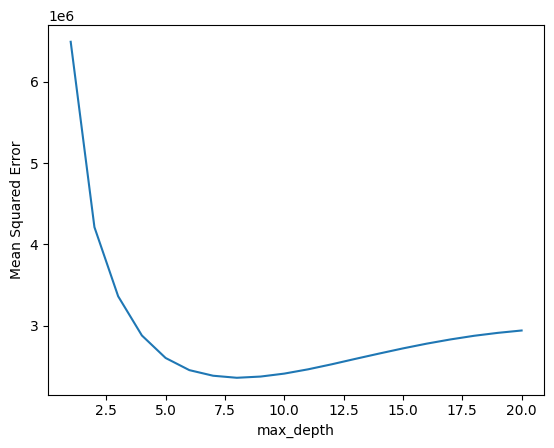

8

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(depth_range, mse_scores_depth)
plt.xlabel('max_depth')
plt.ylabel('Mean Squared Error')
plt.show()
best_depth = depth_range[np.argmin(mse_scores_depth)]
best_depth


In [ ]:
# Calibración de max_features
feature_cols = X.columns
feature_range = range(1, len(feature_cols) + 1)  # Rango de valores para max_features

# Lista para almacenar el error cuadrático medio (MSE) promedio para cada valor de max_features
mse_scores_features = []

# Uso de un 5-fold cross-validation para cada valor de max_features
for feature in feature_range:
    clf = RandomForestRegressor(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    mse_scores_features.append(-1 * cross_val_score(clf, X, y, cv=5, scoring='neg_mean_squared_error').mean())

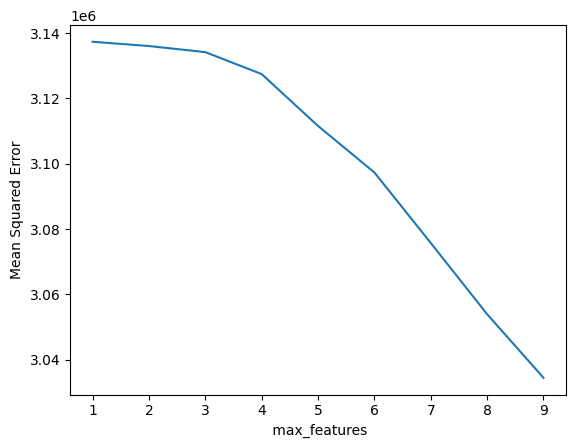

9

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(feature_range, mse_scores_features)
plt.xlabel(' max_features')
plt.ylabel('Mean Squared Error')
plt.show()
best_feature = feature_range[np.argmin(mse_scores_features)]
best_feature

In [ ]:
# Calibración de n_estimators
estimator_range = range(10, 310, 10)  # Rango de valores para n_estimators

# Lista para almacenar el error cuadrático medio (MSE) promedio para cada valor de n_estimators
mse_scores_estimators = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf = RandomForestRegressor(n_estimators=estimator,max_depth=None,max_features='sqrt',random_state=1, n_jobs=-1)
    mse_1 = -1 * cross_val_score(clf, X, y, cv=5, scoring='neg_mean_squared_error').mean()
    mse_scores_estimators.append(mse_1)

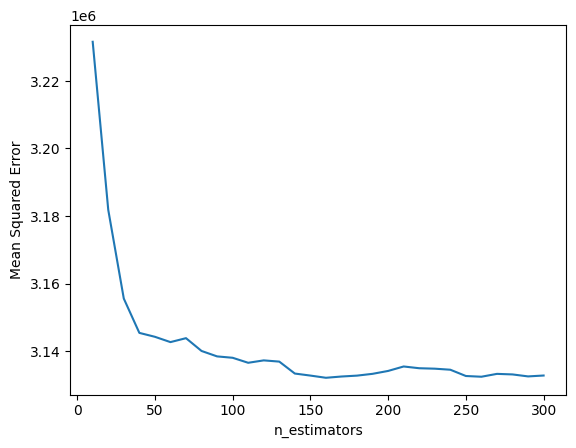

160

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, mse_scores_estimators)
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')
plt.show()
best_estimators = estimator_range[np.argmin(mse_scores_estimators)]
best_estimators

In [ ]:
# Definición del modelo con los mejores parámetros
clf_rfc = RandomForestRegressor(n_estimators=best_estimators,
                             max_depth=best_depth,
                             max_features=best_feature,
                             random_state=1,
                             n_jobs=-1)

# Entrenamiento del modelo
clf_rfc.fit(X_train, y_train)
y_pred = clf_rfc.predict(X_test)
# Calcular métricas de rendimiento
mse_rfc = mean_squared_error(y_test, y_pred)
r2_rfc = r2_score(y_test, y_pred)
rmse_rfc=np.sqrt(mse_rfc)

# Mostrar el desempeño del modelo
print(f'Error cuadrático medio (MSE): {mse_rfc}')
print(f'Coeficiente de determinación (R^2): {r2_rfc}')
print(f'RMSE: {rmse_rfc}')

Error cuadrático medio (MSE): 2450747.4964625672
Coeficiente de determinación (R^2): 0.8397800641771989
RMSE: 1565.4863450259052


El modelo de Random Forest mostrado ha mejorado el rendimiento respecto al anterior, reduciendo el MSE de 3,088,733 a 2,450,747, lo que indica errores de predicción más bajos en general. Además, el RMSE disminuyó de aproximadamente 1,757 a 1,565, lo que significa que el modelo ahora se equivoca en promedio unos $192 menos al predecir el precio de un automóvil. Asimismo, se observa una mejora en el R², que pasó de 0.798 a 0.840, indicando que el modelo actual explica mejor la variabilidad del precio. Estas mejoras reflejan que al optimizar los parametros como los estimadores, las variables y la profundidad del arbol, capturando de manera más precisa las relaciones entre las características (como año, marca y modelo) y el precio del vehículo, lo que lo convierte en una opción más robusta y eficaz.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 6
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Crear y entrenar el modelo de XGBoost
XGBoost_model = XGBRegressor()
XGBoost_model.fit(X_train, y_train)

# Realizar predicciones con el conjunto de prueba
y_pred_XGB = XGBoost_model.predict(X_test)

# Calcular métricas de rendimiento
mse_XGB = mean_squared_error(y_test, y_pred_XGB)
r2_XGB = r2_score(y_test, y_pred_XGB)
rmse_XGB =np.sqrt(mse_XGB)

# Mostrar el desempeño del modelo
print(f'Error cuadrático medio (MSE): {mse_XGB}')
print(f'Coeficiente de determinación (R^2): {r2_XGB}')
print(f'RMSE: {rmse_XGB}')

Error cuadrático medio (MSE): 2576781.0
Coeficiente de determinación (R^2): 0.8315404653549194
RMSE: 1605.2354967418332


En este paso se ha implementado un modelo XGBoost sin ningún tipo de calibración, en relación al problema de estudio. Al final, se obtuvo un error cuadrático medio de 2576781.0, con una raiz cuadrada del error de 1605.23 y un coeficiente de determinación del 83.15%. Con esta última métrica se puede llegar a que el modelo puede explicar aproximadamente el 83.15% de la variación en los precios de los automóviles.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 7
from sklearn.model_selection import GridSearchCV

# Definir el modelo base
XGB_pre_calibrado = XGBRegressor(objective='reg:squarederror', random_state=42)

# Definir los valores a probar para cada hiperparámetro
parametros = {
    'learning_rate': [0.01, 0.05, 0.1],
    'gamma': [0, 1, 5],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

# Realizar búsqueda de hiperparámetros
grid = GridSearchCV(estimator=XGB_pre_calibrado, param_grid=parametros, cv=3,
                    scoring='neg_root_mean_squared_error', verbose=0)
grid.fit(X_train, y_train)

# Obtener el mejor modelo
XGB_calibrado = grid.best_estimator_
print("Mejores parámetros encontrados:", grid.best_params_)

# Evaluar desempeño del mejor modelo
y_pred_XGBc = XGB_calibrado.predict(X_test)

# Calcular métricas de rendimiento
mse_XGBc = mean_squared_error(y_test, y_pred_XGBc)
r2_XGBc = r2_score(y_test, y_pred_XGBc)
rmse_XGBc =np.sqrt(mse_XGBc)

# Mostrar el desempeño del modelo
print(f'Error cuadrático medio (MSE): {mse_XGBc}')
print(f'Coeficiente de determinación (R^2): {r2_XGBc}')
print(f'RMSE: {rmse_XGBc}')

Mejores parámetros encontrados: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.05}
Error cuadrático medio (MSE): 2393679.75
Coeficiente de determinación (R^2): 0.8435109257698059
RMSE: 1547.152141839968


De manera similar como se realizó para la calibración del modelo Ramdom forest, esta vez se utilizó la librería GridSearchCV. Esta busca la mejor combinación de hiperparámetros, en un rango determinado, por medio de validación cruzada. Esto permite optimizar recursos computacionales y encontrar los parámetros óptimos para calibrar con mayor eficiencia. Al final, se encontró que el porcentaje más óptimo de columnas a entrenar para cada árbol (colsample_bytree) es del 70%, el mejor gamma de 0 y el mejor learning rate de 0.05. Con ello, se obtubo un MSE de 2393679.75, con una raiz cuadrada de 1547.15 y un coeficiente de determinación de 0.8435. Con esta última métrica se puede llegar a que el modelo puede explicar aproximadamente el 84.35% de la variación en los precios de los automóviles, un valor mayor al obtenido con el modelo XGBoost sin calibrar.

Para determinar cómo influye la variación de estos parámetros en el modelo, se realizan las siguientes gráficas:



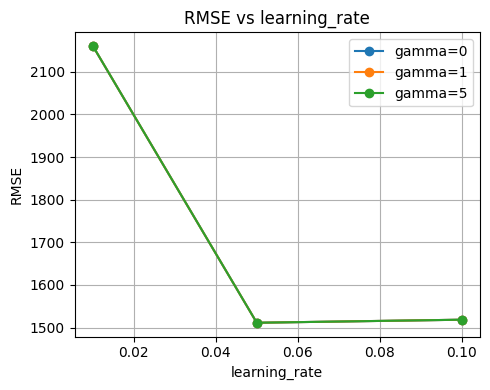

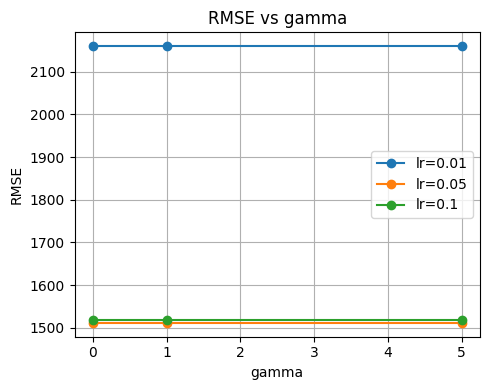

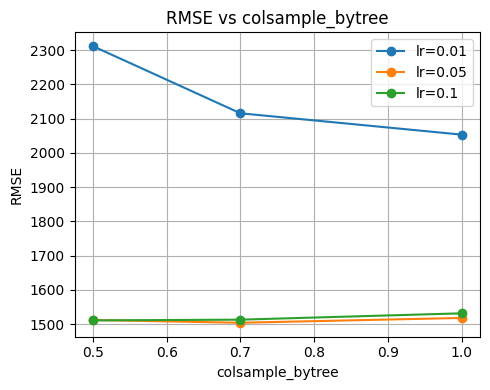

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Obtener los resultados del GridSearch y pasarlos a DataFrame
resultados = pd.DataFrame(grid.cv_results_)

# Cambiar el signo del RMSE (porque 'neg_root_mean_squared_error' lo devuelve negativo)
resultados['mean_RMSE'] = -resultados['mean_test_score']

# Gráfico 1: RMSE vs learning_rate
plt.figure(figsize=(5, 4))
for gamma_val in resultados['param_gamma'].unique():
    subset = resultados[resultados['param_gamma'] == gamma_val]
    means = subset.groupby('param_learning_rate')['mean_RMSE'].mean()
    plt.plot(means.index, means.values, marker='o', label=f'gamma={gamma_val}')
plt.title("RMSE vs learning_rate")
plt.xlabel("learning_rate")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 2: RMSE vs gamma
plt.figure(figsize=(5, 4))
for lr_val in resultados['param_learning_rate'].unique():
    subset = resultados[resultados['param_learning_rate'] == lr_val]
    means = subset.groupby('param_gamma')['mean_RMSE'].mean()
    plt.plot(means.index, means.values, marker='o', label=f'lr={lr_val}')
plt.title("RMSE vs gamma")
plt.xlabel("gamma")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 3: RMSE vs colsample_bytree
plt.figure(figsize=(5, 4))
for lr_val in resultados['param_learning_rate'].unique():
    subset = resultados[resultados['param_learning_rate'] == lr_val]
    means = subset.groupby('param_colsample_bytree')['mean_RMSE'].mean()
    plt.plot(means.index, means.values, marker='o', label=f'lr={lr_val}')
plt.title("RMSE vs colsample_bytree")
plt.xlabel("colsample_bytree")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Las tres gráficas mostradas muestran la variación de la raiz cuadrada del MSE al variar los parámetros. Para cada uno de estos se llega a la siguiente conclusión:
* Learning rate: un valor de este parámetro muy bajo muestra un elevado error en el modelo. Al aumentarlo, se encuentra un punto de inflexión en 0.05 con un menor RMSE y luego nuevamente aumenta. DE esta manera, se concluye que este es el mejor valor ya que aumentar mayor la tasa de aprendizaje el modelo puede terminar en sobreajuste.
* Gamma: este parámetro corresponde al umbral de poda. En la segunda gráfica se observa que las variaciones para este caso no influyen en el desempeño del modelo. A su vez, se observa que en la gráfica 1 los diferentes gamma siguen haciendo que la curva de variación del RMSE con el learning rate siga igual. Por tal razón en este caso se dejó un valor gamma = 0.
* Porcentaje de columnas a entrenar para cada árbol: finalmente, con el mejor learning rate, se observa un punto de inflexión con menor valor de RMSE cuándo el coolsample_bytree es de 0.7.



### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

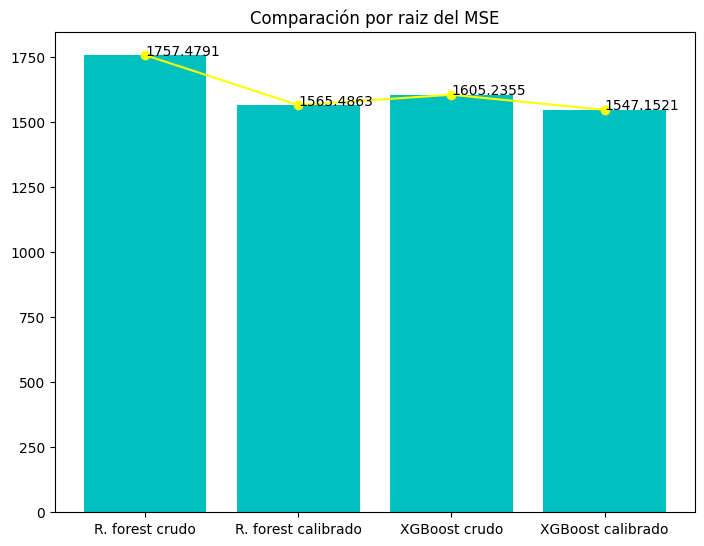

In [ ]:
# Celda 8

# Comparación por RMSE
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación por raiz del MSE")
ejeX = ['R. forest crudo','R. forest calibrado', 'XGBoost crudo','XGBoost calibrado']
ejeY = [round(rmse_rf,4),round(rmse_rfc,4),round(rmse_XGB,4),round(rmse_XGBc,4)]
ax.plot(ejeX, ejeY, marker='o', color='yellow')
ax.bar(ejeX, ejeY, color="c")
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()


Al observar la métrica del RMSE, el modelo con un mayor error es el random forest sin calibrar mientras que el modelo con menor es el XGBoost calibrado. Por tal razón, de acuerdo con esta métrica, el modelo menos eficiente es random forest sin calibrar mientras que el mejor modelo es XGBoost con un colsample_bytree=0.7, gamma=0 y learning_rate=0.05.

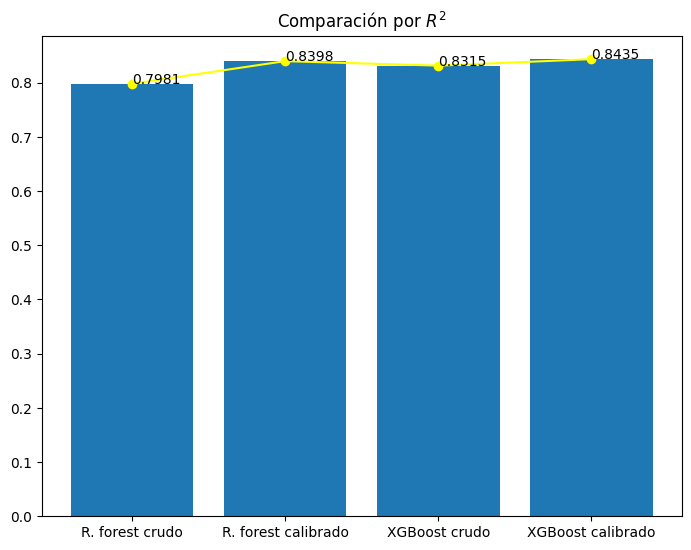

In [ ]:
# Comparación por R2
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación por $R^2$")
ejeX = ['R. forest crudo','R. forest calibrado', 'XGBoost crudo','XGBoost calibrado']
ejeY = [round(r2_rf,4),round(r2_rfc,4),round(r2_XGB,4),round(r2_XGBc,4)]
ax.plot(ejeX, ejeY, marker='o', color='yellow')
ax.bar(ejeX, ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.tight_layout()  # Evita recortes
plt.show()

De manera similar al resultado obtenido con el RMSE, se conserva dicho comportamiento con un menor coeficiente de determinación para el modelo de Random forest sin calibrar y un mayor coeficiente de determinación para el XGBoost calibrado. Este último en su proceso de construcción penaliza modelos más complejos, reevalua en cada iteración los parámetros con validación cruzada y aprende automáticamente el mejor valor para los valores nulos según la pérdida de entrenamiento. Gracias a todas estas optimizaciones en su algoritmo permite obtener mejores resultados en comparación con Random forest. Adicionalmente, por medio de este ejercicio fue posible observar que al no calibrar los parámetros adecuadamente, los modelos tienen menor desempeño.